In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import copy

img = cv2.imread('sar_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Изображение загружено: (634, 952, 3)


In [2]:
# Гауссовский шум
def add_gaussian_noise(image, sigma=100):
    noise = np.random.normal(0, sigma, image.shape)
    noisy = image.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

# Salt & Pepper шум
def add_salt_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05):
    noisy = image.copy()
    # Salt
    salt_mask = np.random.random(image.shape[:2]) < salt_prob
    noisy[salt_mask] = 255
    # Pepper
    pepper_mask = np.random.random(image.shape[:2]) < pepper_prob
    noisy[pepper_mask] = 0
    return noisy

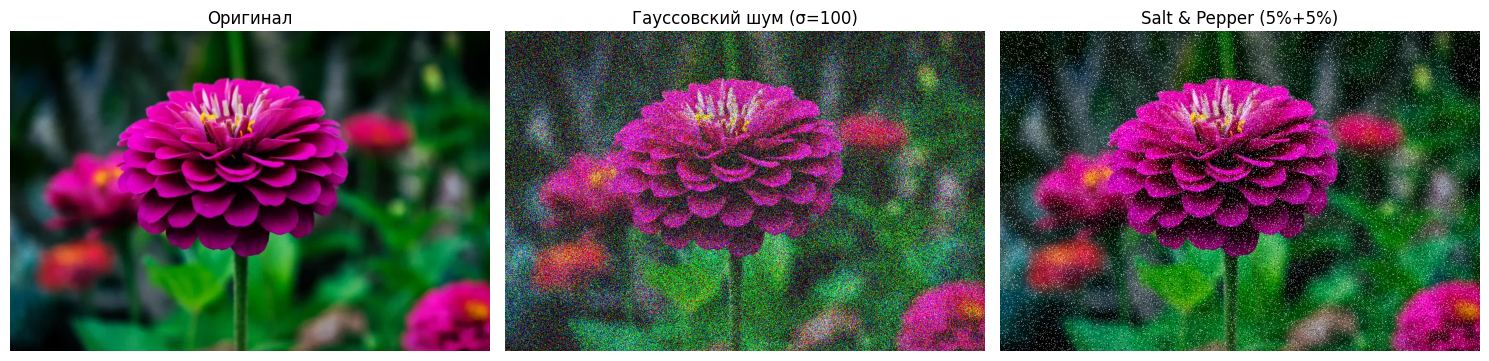

In [3]:
gauss_img = add_gaussian_noise(img, sigma=100)
sp_img = add_salt_pepper_noise(img, salt_prob=0.05, pepper_prob=0.05)

# Визуализация
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Оригинал')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gauss_img)
plt.title('Гауссовский шум')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sp_img)
plt.title('Salt & Pepper')
plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
def apply_all_filters(noisy_img):
    filters = {}
    
    # Медианный
    filters['Медианный 3×3'] = cv2.medianBlur(noisy_img, 3)
    filters['Медианный 5×5'] = cv2.medianBlur(noisy_img, 5)
    filters['Медианный 7×7'] = cv2.medianBlur(noisy_img, 7)
    
    # Гауссов
    filters['Гаусс 3×3'] = cv2.GaussianBlur(noisy_img, (3,3), 0)
    filters['Гаусс 5×5'] = cv2.GaussianBlur(noisy_img, (5,5), 1)
    filters['Гаусс 7×7'] = cv2.GaussianBlur(noisy_img, (7,7), 2)
    
    # Билатеральный
    filters['Билатеральный (d=9, σ=75)'] = cv2.bilateralFilter(noisy_img, 9, 75, 75)
    filters['Билатеральный (d=15, σ=100)'] = cv2.bilateralFilter(noisy_img, 15, 100, 100)
    filters['Билатеральный (d=15, σ=150)'] = cv2.bilateralFilter(noisy_img, 15, 150, 150)
    
    # Нелокальные средние
    filters['NLM (h=10)'] = cv2.fastNlMeansDenoisingColored(noisy_img, None, 10, 10, 7, 21)
    filters['NLM (h=20)'] = cv2.fastNlMeansDenoisingColored(noisy_img, None, 20, 20, 7, 21)
    filters['NLM (h=30)'] = cv2.fastNlMeansDenoisingColored(noisy_img, None, 30, 30, 7, 21)
    
    return filters

gauss_filters = apply_all_filters(gauss_img)
sp_filters = apply_all_filters(sp_img)

In [5]:
def calculate_metrics(original, filtered):
    p = psnr(original, filtered)
    s = ssim(original, filtered, channel_axis=-1, data_range=255)
    return p, s

# Для зашумлённых
psnr_gauss_noise, ssim_gauss_noise = calculate_metrics(img, gauss_img)
psnr_sp_noise, ssim_sp_noise = calculate_metrics(img, sp_img)

print("МЕТРИКИ ЗАШУМЛЁННЫХ ИЗОБРАЖЕНИЙ:")
print(f"Гауссовский шум:  PSNR = {psnr_gauss_noise:.2f} дБ, SSIM = {ssim_gauss_noise:.4f}")
print(f"Salt & Pepper:    PSNR = {psnr_sp_noise:.2f} дБ, SSIM = {ssim_sp_noise:.4f}")

МЕТРИКИ ЗАШУМЛЁННЫХ ИЗОБРАЖЕНИЙ:
Гауссовский шум:  PSNR = 10.73 дБ, SSIM = 0.0290
Salt & Pepper:    PSNR = 14.43 дБ, SSIM = 0.1310


In [6]:
def get_top_results(original, filters_dict, top_n=5):
    results = []
    for name, filtered in filters_dict.items():
        p, s = calculate_metrics(original, filtered)
        results.append((name, p, s, filtered))
    
    
    results.sort(key=lambda x: x[2], reverse=True)
    return results[:top_n]


top_gauss = get_top_results(img, gauss_filters, 5)
top_sp = get_top_results(img, sp_filters, 5)

print("ТОП-5 ФИЛЬТРОВ ПО SSIM")

print("\nГАУССОВСКИЙ ШУМ:")
for i, (name, p, s, _) in enumerate(top_gauss, 1):
    print(f"{i}. {name:<30} → PSNR: {p:6.2f} дБ | SSIM: {s:.4f}")

print("\nSALT & PEPPER ШУМ:")
for i, (name, p, s, _) in enumerate(top_sp, 1):
    print(f"{i}. {name:<30} → PSNR: {p:6.2f} дБ | SSIM: {s:.4f}")

ТОП-5 ФИЛЬТРОВ ПО SSIM

ГАУССОВСКИЙ ШУМ:
1. Гаусс 7×7                      → PSNR:  18.95 дБ | SSIM: 0.3879
2. Медианный 7×7                  → PSNR:  23.38 дБ | SSIM: 0.3791
3. Медианный 5×5                  → PSNR:  21.02 дБ | SSIM: 0.2438
4. Гаусс 5×5                      → PSNR:  17.78 дБ | SSIM: 0.1879
5. Гаусс 3×3                      → PSNR:  16.80 дБ | SSIM: 0.1282

SALT & PEPPER ШУМ:
1. Медианный 3×3                  → PSNR:  40.92 дБ | SSIM: 0.9857
2. Медианный 5×5                  → PSNR:  38.91 дБ | SSIM: 0.9729
3. Медианный 7×7                  → PSNR:  36.34 дБ | SSIM: 0.9583
4. NLM (h=30)                     → PSNR:  24.00 дБ | SSIM: 0.6300
5. Гаусс 7×7                      → PSNR:  26.15 дБ | SSIM: 0.6144


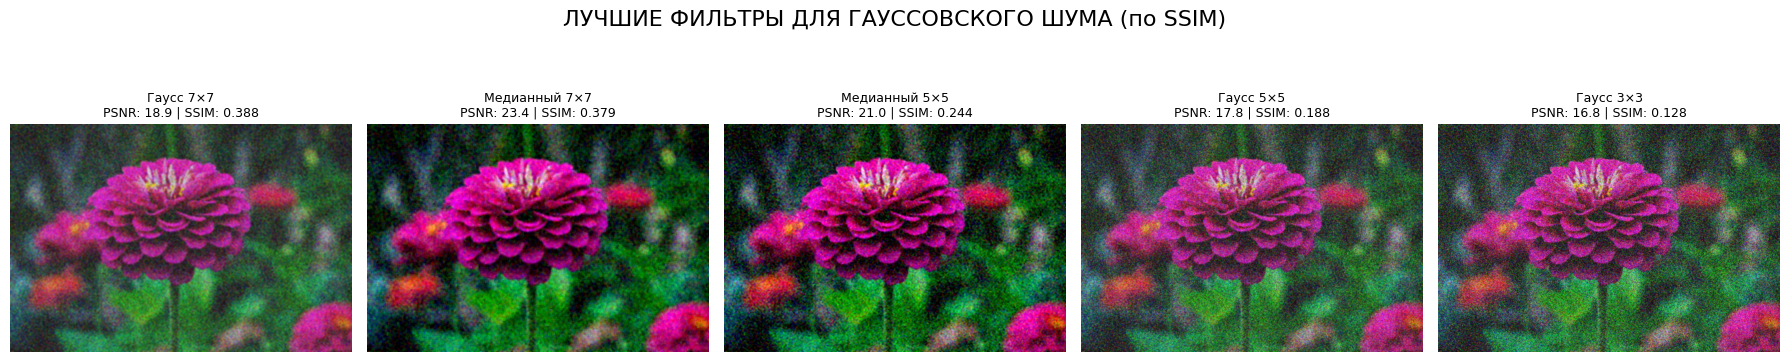

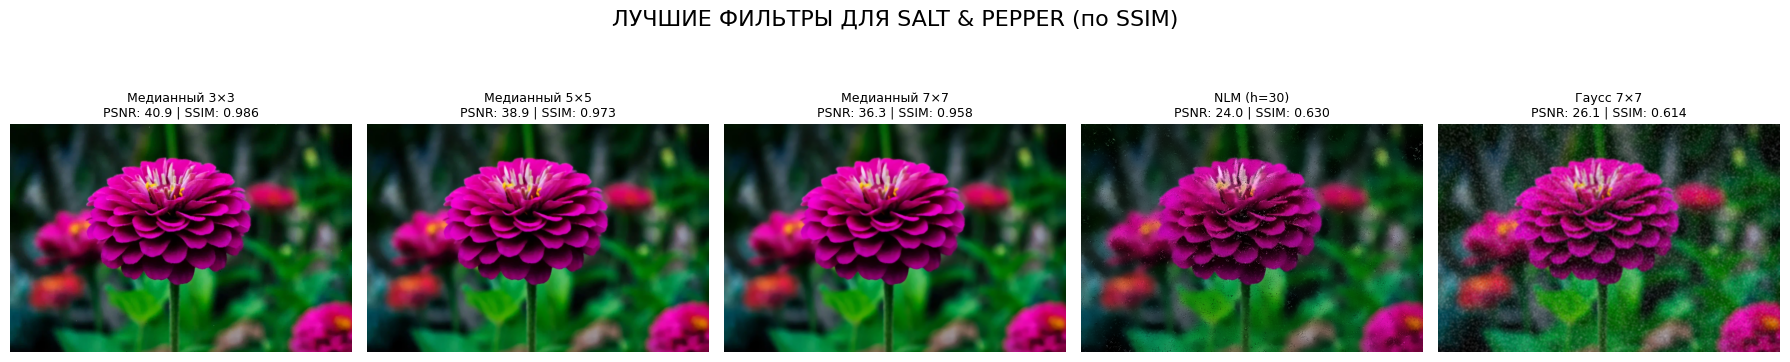

In [7]:
# Гауссовский шум
plt.figure(figsize=(18, 8))
plt.suptitle('ЛУЧШИЕ ФИЛЬТРЫ ДЛЯ ГАУССОВСКОГО ШУМА (по SSIM)', fontsize=16, y=0.98)

for i, (name, p, s, filtered) in enumerate(top_gauss, 1):
    plt.subplot(2, 5, i)
    plt.imshow(filtered)
    plt.title(f'{name}\nPSNR: {p:.1f} | SSIM: {s:.3f}', fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Salt & Pepper
plt.figure(figsize=(18, 8))
plt.suptitle('ЛУЧШИЕ ФИЛЬТРЫ ДЛЯ SALT & PEPPER (по SSIM)', fontsize=16, y=0.98)

for i, (name, p, s, filtered) in enumerate(top_sp, 1):
    plt.subplot(2, 5, i)
    plt.imshow(filtered)
    plt.title(f'{name}\nPSNR: {p:.1f} | SSIM: {s:.3f}', fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()